In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === CONFIGURATION ===
IMG_SIZE = 224
DATA_DIR = r'D:\NIH Xray Dataset'
CSV_PATH = os.path.join(DATA_DIR, 'Data_Entry_2017.csv')
target_classes = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Pneumonia', 'No Finding']

# === STEP 1: Load and Filter Dataset ===
df = pd.read_csv(CSV_PATH)
df['Finding Labels'] = df['Finding Labels'].str.strip()
df_single = df[df['Finding Labels'].isin(target_classes)]

# === STEP 2: Balance Dataset ===
min_count = df_single['Finding Labels'].value_counts().min()
df_balanced = pd.concat([
    df_single[df_single['Finding Labels'] == cls].sample(min_count, random_state=43)
    for cls in target_classes
])
df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)

# Helper function to find image in any of the image folders
def find_image_path(image_name, data_dir):
    """Search for image in folders images_001 to images_012"""
    for i in range(1, 13):  # folders images_001 to images_012
        folder_name = f'images_{i:03d}'  # formats as images_001, images_002, etc.
        img_path = os.path.join(data_dir, folder_name, image_name)
        if os.path.exists(img_path):
            return img_path
    return None

### DEBUG: Check if dataset is loaded and balanced
print("Dataset loaded and balanced. Number of samples per class:")
print(df_balanced['Finding Labels'].value_counts())
# show a sample of the dataset, images are in folders \images_001 to \images_012
print("\nSample data:")
print(df_balanced.head())


Dataset loaded and balanced. Number of samples per class:
Finding Labels
Atelectasis     322
Effusion        322
No Finding      322
Pneumonia       322
Cardiomegaly    322
Name: count, dtype: int64

Sample data:
        Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00015468_000.png    Atelectasis            0       15468           38   
1  00008051_006.png    Atelectasis            6        8051           49   
2  00028628_006.png       Effusion            6       28628           20   
3  00000618_000.png     No Finding            0         618           54   
4  00020773_003.png    Atelectasis            3       20773           20   

  Patient Gender View Position  OriginalImage[Width  Height]  \
0              M            PA                 2992     2991   
1              M            AP                 2500     2048   
2              M            PA                 1767     2021   
3              F            PA                 2596     2364   
4        

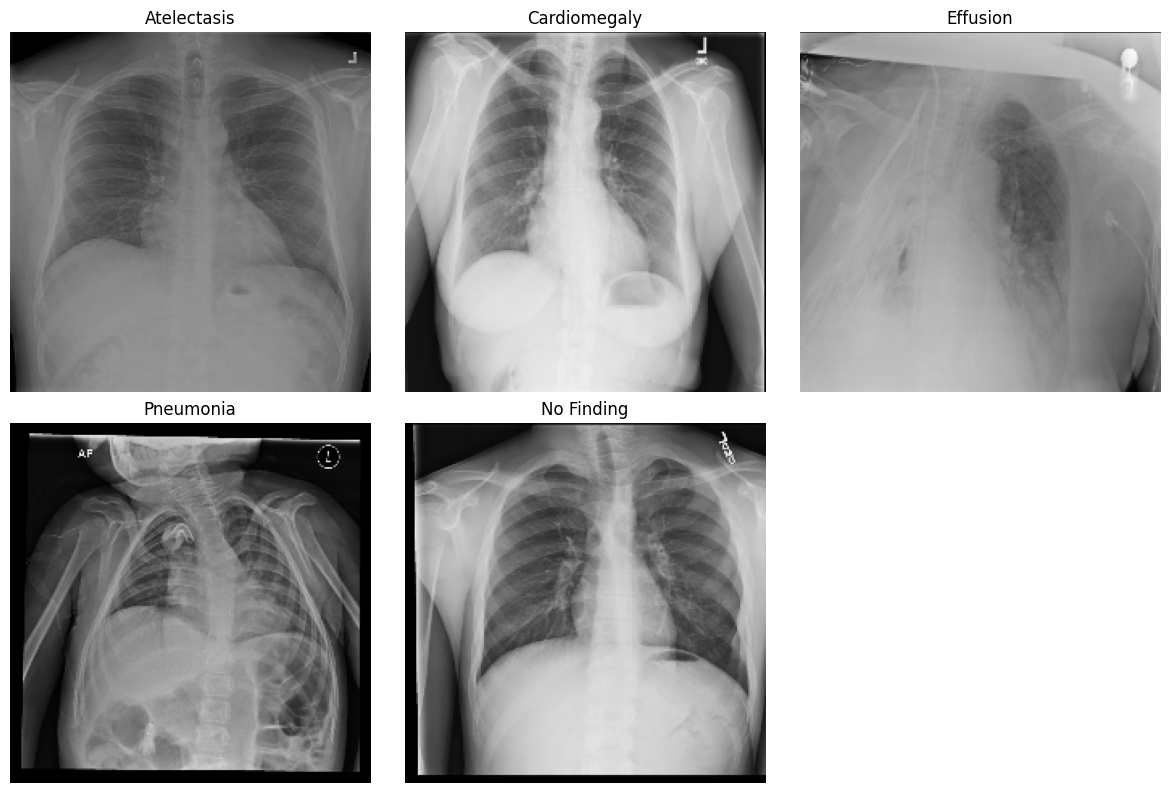

In [ ]:
# helper function to find image path in subfolders
def find_image_path(file_name, base_dir):
    for i in range(1, 13):
        sub_dir = os.path.join(base_dir, f'images_{i:03d}')
        sub_dir = sub_dir + "\images"
        file_path = os.path.join(sub_dir, file_name)
        if os.path.exists(file_path):
            return file_path
    return None

# === STEP 3: Prepare Data for Training ===
def preprocess_image(file_name):
    file_path = find_image_path(file_name, DATA_DIR)
    # DEBUG----------------------------
    print(f"[INFO] Processing image: {file_name} from {file_path}")
    if file_path:
        img = cv2.imread(file_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.GaussianBlur(img, (5, 5), 0)
        return img
    print(f"[WARN] Image not found: {file_name}")
    return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # fallback: black image

### DEBUG: show image sample from each class
def show_sample_images(df):
    plt.figure(figsize=(12, 8))
    for i, cls in enumerate(target_classes):
        sample = df[df['Finding Labels'] == cls].sample(1)
        img_path = find_image_path(sample['Image Index'].values[0], DATA_DIR)
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            plt.subplot(2, 3, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
show_sample_images(df_balanced)


In [12]:
# === STEP 4: Preprocess All Images and Labels ===

# Convert labels to integer indices
label_to_index = {label: idx for idx, label in enumerate(target_classes)}
df_balanced['Label Index'] = df_balanced['Finding Labels'].map(label_to_index)
### DEBUG: Check label mapping
print("Label mapping:")

# Preprocess images
images = np.array([preprocess_image(fname) for fname in df_balanced['Image Index']])
labels = to_categorical(df_balanced['Label Index'].values, num_classes=len(target_classes))

print(f"[INFO] Total images: {images.shape}, Labels: {labels.shape}")

Label mapping:
[INFO] Processing image: 00015468_000.png from D:\NIH Xray Dataset\images_007\images\00015468_000.png
[INFO] Processing image: 00008051_006.png from D:\NIH Xray Dataset\images_004\images\00008051_006.png
[INFO] Processing image: 00028628_006.png from D:\NIH Xray Dataset\images_012\images\00028628_006.png
[INFO] Processing image: 00000618_000.png from D:\NIH Xray Dataset\images_001\images\00000618_000.png
[INFO] Processing image: 00020773_003.png from D:\NIH Xray Dataset\images_009\images\00020773_003.png
[INFO] Processing image: 00013557_001.png from D:\NIH Xray Dataset\images_006\images\00013557_001.png
[INFO] Processing image: 00011391_006.png from D:\NIH Xray Dataset\images_005\images\00011391_006.png
[INFO] Processing image: 00015732_026.png from D:\NIH Xray Dataset\images_007\images\00015732_026.png
[INFO] Processing image: 00013862_004.png from D:\NIH Xray Dataset\images_007\images\00013862_004.png
[INFO] Processing image: 00014186_001.png from D:\NIH Xray Dataset\

In [13]:
# === STEP 5: Train / Val / Final Test Split ===

# 20% of entire dataset for final test
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Split remaining 80% into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print(f"[INFO] Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

[INFO] Train: (1030, 224, 224, 3), Val: (258, 224, 224, 3), Test: (322, 224, 224, 3)


In [14]:
# === STEP 6: Data Augmentation ===
train_aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_aug = ImageDataGenerator()  # No augmentation for val/test

In [15]:
# === STEP 7: Build MobileNetV2 CNN ===

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(target_classes), activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1

In [ ]:
# === STEP 8: Train Model ===
BATCH_SIZE = 32
EPOCHS = 50

history = model.fit(
    train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=val_aug.flow(X_val, y_val),
    epochs=EPOCHS
)


Epoch 1/50
33/33 [==============================] - 24s 730ms/step - loss: 1.5001 - accuracy: 0.3417 - val_loss: 1.5582 - val_accuracy: 0.3062
Epoch 2/50
Epoch 2/50
33/33 [==============================] - 26s 775ms/step - loss: 1.5252 - accuracy: 0.3058 - val_loss: 1.5573 - val_accuracy: 0.3101
Epoch 3/50
33/33 [==============================] - 26s 775ms/step - loss: 1.5252 - accuracy: 0.3058 - val_loss: 1.5573 - val_accuracy: 0.3101
Epoch 3/50
33/33 [==============================] - 24s 737ms/step - loss: 1.4999 - accuracy: 0.3437 - val_loss: 1.5480 - val_accuracy: 0.3217
Epoch 4/50
33/33 [==============================] - 24s 737ms/step - loss: 1.4999 - accuracy: 0.3437 - val_loss: 1.5480 - val_accuracy: 0.3217
Epoch 4/50
33/33 [==============================] - 25s 743ms/step - loss: 1.4954 - accuracy: 0.3398 - val_loss: 1.5366 - val_accuracy: 0.3372
Epoch 5/50
Epoch 5/50
33/33 [==============================] - 27s 819ms/step - loss: 1.4907 - accuracy: 0.3515 - val_loss: 1.5485 

In [17]:
# === STEP 9: Evaluate Final Test Accuracy ===
loss, acc = model.evaluate(val_aug.flow(X_test, y_test), verbose=1)
print(f"[RESULT] Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")


11/11 [==============================] - 4s 351ms/step - loss: 1.5887 - accuracy: 0.2640
[RESULT] Test Accuracy: 0.2640, Loss: 1.5887
11/11 [==============================] - 4s 351ms/step - loss: 1.5887 - accuracy: 0.2640
[RESULT] Test Accuracy: 0.2640, Loss: 1.5887


In [ ]:
# show 5 images of each type in the test set
def show_test_samples(df, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i, cls in enumerate(target_classes):
        sample = df[df['Finding Labels'] == cls].sample(num_samples)
        for j, row in sample.iterrows():
            img_path = find_image_path(row['Image Index'], DATA_DIR)
            if img_path:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                plt.subplot(num_samples, len(target_classes), i * num_samples + j + 1)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title(cls)
                plt.axis('off')
    plt.tight_layout()
    plt.show()

show_test_samples(df_balanced, num_samples=5)


In [12]:
### Train/Validation/Test Split
from sklearn.model_selection import train_test_split

# 80% train, 10% val, 10% test
train_df, test_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['Finding Labels'])

train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['Finding Labels'], random_state=42)

### DEBUG: Display the splits and percentages
print("\nDataset splits:")
print(f"Train samples: {len(train_df)}, {len(train_df)/len(df_balanced)*100:.2f}%")
print(f"Validation samples: {len(val_df)}, {len(val_df)/len(df_balanced)*100:.2f}%")
print(f"Test samples: {len(test_df)}, {len(test_df)/len(df_balanced)*100:.2f}%")
# Display pixel dimensions (width x height) for a few images in the dataset
print("\nSample image dimensions (pixels):")
for idx, row in df_balanced.head(5).iterrows():
    width = row['OriginalImage[Width']
    height = row['Height]']
    print(f"{row['Image Index']}: {width}x{height}")

### DEBUG: Display class distribution in each split
print("\nClass distribution in splits:")
print("Train:\n", train_df['Finding Labels'].value_counts())
print("Validation:\n", val_df['Finding Labels'].value_counts())
print("Test:\n", test_df['Finding Labels'].value_counts())



Dataset splits:
Train samples: 1159, 71.99%
Validation samples: 129, 8.01%
Test samples: 322, 20.00%

Sample image dimensions (pixels):
00015468_000.png: 2992x2991
00008051_006.png: 2500x2048
00028628_006.png: 1767x2021
00000618_000.png: 2596x2364
00020773_003.png: 2578x2991

Class distribution in splits:
Train:
 Finding Labels
Pneumonia       232
No Finding      232
Effusion        232
Cardiomegaly    232
Atelectasis     231
Name: count, dtype: int64
Validation:
 Finding Labels
Cardiomegaly    26
Pneumonia       26
Effusion        26
Atelectasis     26
No Finding      25
Name: count, dtype: int64
Test:
 Finding Labels
Atelectasis     65
No Finding      65
Cardiomegaly    64
Effusion        64
Pneumonia       64
Name: count, dtype: int64
